In [1]:
# Pytorch packages
import torch
from torch_geometric.data import Data
import torch.nn as nn
import torch_geometric.nn as pyg_nn
from torch_geometric.utils import to_networkx
from torch_geometric.utils import add_self_loops, degree

# Other packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx
import meshio

In [2]:
# CUDA support
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

print(f"Using device: {device}")

Using device: cuda


In [3]:
mesh_file = "meshes/hole_middle_r10_o1.inp"
csv_file = "data/hole_middle_r10_al.csv"

mesh = meshio.read(mesh_file)
df = pd.read_csv(csv_file, sep=',', skipinitialspace=True)

In [4]:
bc_pts = mesh.point_sets

# Free surface
# Fixed
# Force

wall = bc_pts["wall_left"]
print(wall)

[  0   3 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121
 122 123 124]


In [5]:
class Geometry():
    def __init__(self, mesh_file, data_file):

        self.mesh = meshio.read(mesh_file)
        self.node_pos = torch.tensor(self.mesh.points[:, :2], dtype=torch.float, device=device)
        self.mesh_size = self.mesh.points.shape[0]

        self.df = pd.read_csv(data_file, sep=',', skipinitialspace=True)
        self.df = self.df.iloc[:self.mesh_size]

        self.create_dataset()
        self.create_graph()
        self.get_boundary_points()

    def create_dataset(self):
        von_miss = self.df["Equivalent Stress"].values
        stress_x = self.df["Stress X"].values
        stress_y = self.df["Stress Y"].values
        deform_x = self.df["Deformation X"].values
        deform_y = self.df["Deformation Y"].values
        shear = self.df["Shear"].values

        self.von_miss = torch.tensor(von_miss, dtype=torch.float).view(-1, 1)
        self.sxx = torch.tensor(stress_x, dtype=torch.float).view(-1, 1)
        self.syy = torch.tensor(stress_y, dtype=torch.float).view(-1, 1)
        self.u = torch.tensor(deform_x, dtype=torch.float).view(-1, 1)
        self.v = torch.tensor(deform_y, dtype=torch.float).view(-1, 1)
        self.sxy = torch.tensor(shear, dtype=torch.float).view(-1, 1)

        self.target_data = torch.cat([self.u, self.v, self.sxx, self.syy, self.sxy], dim=1).to(device)

    def create_graph(self):
        edges = []
        for cell in self.mesh.cells:
            if cell.type == "triangle":
                for element in cell.data:
                    edges.append([element[0], element[1]])
                    edges.append([element[1], element[0]])

                    edges.append([element[1], element[2]])
                    edges.append([element[2], element[1]])

                    edges.append([element[2], element[0]])
                    edges.append([element[0], element[2]])

        edges = torch.tensor(edges, dtype=torch.long, device=device).t().contiguous()
        
        source_nodes = edges[0]
        target_nodes = edges[1]

        source_pos = self.node_pos[source_nodes]
        target_pos = self.node_pos[target_nodes]
        edge_length = torch.norm(source_pos - target_pos, dim=1, keepdim=True)
        
        self.graph = Data(x=self.node_pos, edge_index=edges, edge_attr=edge_length).to(device)
        self.graph.x.requires_grad_(True)

        print(self.graph)

    def get_boundary_points(self):
        self.bc_pts = self.mesh.point_sets
        self.keys = self.bc_pts.keys()

        
        

In [6]:
obj = Geometry(mesh_file, csv_file)

Data(x=[5529, 2], edge_index=[2, 64176], edge_attr=[64176, 1])


In [7]:
data = obj.graph

G = to_networkx(data, to_undirected=True)

pos = {i: (data.x[i, 0].item(), data.x[i, 1].item()) for i in range(data.x.shape[0])}

stress = obj.df["Equivalent Stress"].values.reshape(-1, 1)
print(stress)

[[87043895.3529]
 [49995090.6478]
 [49996027.4999]
 ...
 [79613179.7095]
 [32055405.1279]
 [38843549.5274]]


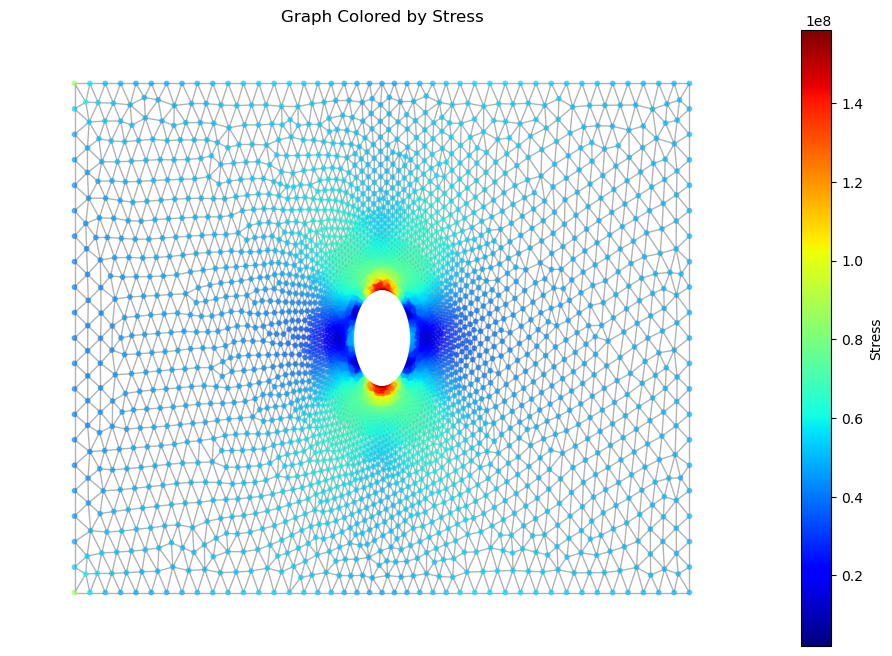

In [8]:
fig, ax = plt.subplots(figsize=(12, 8))

# Draw the graph on the given axis
nx.draw(G, pos, node_size=10, edge_color="gray", alpha=0.6,
        node_color=stress, cmap="jet", vmin=stress.min(), vmax=stress.max(),
        ax=ax)

# Create a mappable and assign the stress values to it for the colorbar
mappable = plt.cm.ScalarMappable(cmap="jet")
mappable.set_array(stress)

# Add the colorbar to the figure, using the axis
fig.colorbar(mappable, ax=ax, label="Stress")

ax.set_title("Graph Colored by Stress")
plt.show()

In [9]:
class MPNN(pyg_nn.MessagePassing):
    def __init__(self, latent_size, in_edge_size, in_node_size):
        super(MPNN, self).__init__(aggr="add")
        
        self.latent_size = latent_size

        self.edge_net = nn.Sequential(
            nn.Linear(in_edge_size, latent_size),
            nn.ReLU(),
            nn.Linear(latent_size, latent_size),
            nn.ReLU(),
            nn.LayerNorm(latent_size)
        )

        self.node_net = nn.Sequential(
            nn.Linear(in_node_size, latent_size),
            nn.ReLU(),
            nn.Linear(latent_size, latent_size),
            nn.ReLU(),
            nn.LayerNorm(latent_size)
        )

    def forward(self, x, edge_index, edge_attr):
        aggr_messages = self.propagate(edge_index, x=x, edge_attr=edge_attr)

        updated_nodes = self.node_net(torch.cat([x, aggr_messages], dim=1))

        row, col = edge_index
        updated_edges = self.edge_net(torch.cat([x[row], x[col], edge_attr], dim=1))

        return updated_nodes, updated_edges
    
    def message(self, x_i, x_j, edge_attr):
        msg = torch.cat([x_i, x_j, edge_attr], dim=1)
        return self.edge_net(msg)
    
    def update(self, aggr_out):
        return aggr_out
    

class EncodeProcessDecode(nn.Module):
    def __init__(self, node_feat_size, edge_feat_size, latent_size, output_size, num_layers):
        super(EncodeProcessDecode, self).__init__()

        self.latent_size = latent_size

        # Node encoder: maps raw node features to latent space.
        self.node_encoder = nn.Sequential(
            nn.Linear(node_feat_size, latent_size),
            nn.ReLU(),
            nn.Linear(latent_size, latent_size),
            nn.ReLU(),
            nn.LayerNorm(latent_size)
        )
        # Edge encoder: maps raw edge features to latent space.
        self.edge_encoder = nn.Sequential(
            nn.Linear(edge_feat_size, latent_size),
            nn.ReLU(),
            nn.Linear(latent_size, latent_size),
            nn.ReLU(),
            nn.LayerNorm(latent_size)
        )
        
        # Processor: stack of message-passing blocks.
        self.layers = nn.ModuleList([
            MPNN(latent_size, latent_size * 3, latent_size * 2)
            for _ in range(num_layers)
        ])
        
        # Decoder: maps latent node features to final predictions (5 variables per node).
        self.node_decoder = nn.Sequential(
            nn.Linear(latent_size, latent_size),
            nn.ReLU(),
            nn.Linear(latent_size, output_size)
        )

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr

        x = self.node_encoder(x)
        edge_attr = self.edge_encoder(edge_attr)

        for layer in self.layers:
            x_res, edge_res = x, edge_attr
            x, edge_attr = layer(x, edge_index, edge_attr)
            x = x + x_res
            edge_attr = edge_attr + edge_res
        
        out = self.node_decoder(x)
        return out


In [14]:
class PlateSolver():
    def __init__(self, obj):
        self.data = obj.graph
        self.bc_pts = obj.bc_pts

        self.wall_left = self.bc_pts["wall_left"]
        self.free_bot = self.bc_pts["free_bot"]
        self.force_right = self.bc_pts["force_right"]
        self.free_top = self.bc_pts["free_top"]
        self.hole1 = self.bc_pts["hole1"]

        self.target = obj.target_data

        self.E = 7e10
        self.sigma_0 = 50e6
        self.U = self.sigma_0 / self.E
        self.nu = 0.33

        self.node_feat_size = 2
        self.edge_feat_size = 1
        self.latent_size = 64
        self.output_size = 5
        self.num_layers = 3

        self.iter = 0

        self.adam_lr = 0.005

        self.model = EncodeProcessDecode(self.node_feat_size, self.edge_feat_size, self.latent_size, self.output_size, self.num_layers).to(device)
        
        self.optimizer_adam = torch.optim.Adam(self.model.parameters(), lr=self.adam_lr)

        self.optimizer_lbfgs = torch.optim.LBFGS(
            self.model.parameters(),
            lr=0.05,
            max_iter=2000,
            max_eval=2000,
            history_size=200,
            tolerance_grad=1e-20,
            tolerance_change=1e-20,
        )
        self.loss_fn = nn.MSELoss()

    def model_value(self, data):
        out = self.model(data)
        u = out[:, 0:1]
        v = out[:, 1:2]
        sxx = out[:, 2:3]
        syy = out[:, 3:4]
        sxy = out[:, 4:5]
        return u, v, sxx, syy, sxy

    def data_loss(self, data, u, v, sxx, syy, sxy):

        ut = self.target[:, 0:1] / self.U
        vt = self.target[:, 1:2] / self.U
        sxxt = self.target[:, 2:3] / self.sigma_0
        syyt = self.target[:, 3:4] / self.sigma_0
        sxyt = self.target[:, 4:5] / self.sigma_0

        out = torch.cat([u, v, sxx, syy, sxy], dim=1)
        target = torch.cat([ut, vt, sxxt, syyt, sxyt], dim=1)

        d = self.loss_fn(out, target)
        return d

    def pde_loss(self, data, u, v, sxx, syy, sxy):

        du = torch.autograd.grad(u, data.x, torch.ones_like(u), create_graph=True)[0]
        du_x = du[:, 0:1]
        du_y = du[:, 1:2]

        dv = torch.autograd.grad(v, data.x, torch.ones_like(v), create_graph=True)[0]
        dv_x = dv[:, 0:1]
        dv_y = dv[:, 1:2]
    
        dsxx_x = torch.autograd.grad(sxx, data.x, torch.ones_like(sxx), create_graph=True)[0][:, 0:1]
        dsyy_y = torch.autograd.grad(syy, data.x, torch.ones_like(syy), create_graph=True)[0][:, 1:2]
        
        dsxy = torch.autograd.grad(sxy, data.x, torch.ones_like(sxy), create_graph=True)[0]
        dsxy_x = dsxy[:, 0:1]
        dsxy_y = dsxy[:, 1:2]

        term_xx = 1 / (1 - self.nu**2) * (du_x + self.nu*dv_y)
        term_yy = 1 / (1 - self.nu**2) * (dv_y + self.nu*du_x)
        term_xy = 1 / (2*(1 + self.nu)) * (du_y + dv_x)

        r1 = torch.mean(torch.pow((sxx - term_xx), 2))
        r2 = torch.mean(torch.pow((syy - term_yy), 2))
        r3 = torch.mean(torch.pow((sxy - term_xy), 2))
        r4 = torch.mean(torch.pow((dsxx_x + dsxy_y), 2))
        r5 = torch.mean(torch.pow((dsyy_y + dsxy_x), 2))

        residual = r1 + r2 + r3 + r4 + r5
        return residual

    def bc_loss(self, data, u, v, sxx, syy, sxy):

        b = torch.mean(torch.pow(u[self.wall_left], 2))
        b += torch.mean(torch.pow(v[self.wall_left], 2))

        b += torch.mean(torch.pow(syy[self.free_top], 2))
        b += torch.mean(torch.pow(sxy[self.free_top], 2))

        b += torch.mean(torch.pow(sxx[self.force_right] - 1, 2))
        b += torch.mean(torch.pow(sxy[self.force_right], 2))

        b += torch.mean(torch.pow(syy[self.free_bot], 2))
        b += torch.mean(torch.pow(sxy[self.free_bot], 2))

        x = data.x[:, 0:1]
        y = data.x[:, 1:2]
        nx = - (x[self.hole1] - 1) / 0.1
        ny = - (y[self.hole1] - 0.5) / 0.1
        tx = torch.mul(sxx[self.hole1], nx) + torch.mul(sxy[self.hole1], ny)
        ty = torch.mul(sxy[self.hole1], nx) + torch.mul(syy[self.hole1], ny)

        b += torch.mean(torch.pow(tx, 2))
        b += torch.mean(torch.pow(ty, 2))

        return b

    def loss_func(self, data):
        u, v, sxx, syy, sxy = self.model_value(data)
        target = self.data_loss(data, u, v, sxx, syy, sxy)
        # pde = self.pde_loss(data, u, v, sxx, syy, sxy)
        # bc = self.bc_loss(data, u, v, sxx, syy, sxy)

        total_loss = target
        return total_loss

    def closure(self):
        self.optimizer_lbfgs.zero_grad()
        loss = self.loss_func(self.data)
        loss.backward()

        if self.iter % 100 == 0:
            print(f"Iter: {self.iter}, Loss: {'{:e}'.format(loss.item())}")
        self.iter += 1
        return loss

    def train(self, epochs=1000):
        self.model.train()

        for epoch in range(epochs):
            self.optimizer_adam.zero_grad()

            loss = self.loss_func(self.data)
            loss.backward()
            self.optimizer_adam.step()

            if epoch % 100 == 0:
                print(f"Epoch {epoch}, Loss: {'{:e}'.format(loss.item())}")

        # self.optimizer_lbfgs.step(self.closure)
        

In [15]:
obj = Geometry(mesh_file, csv_file)

Data(x=[5529, 2], edge_index=[2, 64176], edge_attr=[64176, 1])


In [24]:
data = obj.graph
print(data.edge_attr)

tensor([[0.0173],
        [0.0173],
        [0.0199],
        ...,
        [0.0037],
        [0.0037],
        [0.0037]], device='cuda:0')


In [16]:
test = PlateSolver(obj)

In [17]:
%%time
test.train(1000)

Epoch 0, Loss: 1.334288e+00
Epoch 100, Loss: 1.037950e-01
Epoch 200, Loss: 4.437456e-02
Epoch 300, Loss: 2.410813e-02
Epoch 400, Loss: 7.817750e-03
Epoch 500, Loss: 2.870630e-03
Epoch 600, Loss: 2.091952e-03
Epoch 700, Loss: 1.224047e-03
Epoch 800, Loss: 6.427849e-04
Epoch 900, Loss: 5.578772e-04
CPU times: total: 34.2 s
Wall time: 1min 30s


In [ ]:
# Save model
torch.save(test.model.state_dict(), "models/plate_hole_test2.pth")

In [ ]:
mesh_file = "meshes/hole_middle_r10_test.inp"
obj = Geometry(mesh_file, csv_file)

In [18]:
data = obj.graph
out = test.model(data)

In [19]:
E = 7e10
sigma_0 = 50e6
U = sigma_0 / E


In [20]:
G = to_networkx(data, to_undirected=True)

pos = {i: (data.x[i, 0].item(), data.x[i, 1].item()) for i in range(data.x.shape[0])}

u = out[:, 0:1].detach().cpu().numpy()
v = out[:, 1:2].detach().cpu().numpy()
sxx = out[:, 2:3].detach().cpu().numpy()
syy = out[:, 3:4].detach().cpu().numpy()
sxy = out[:, 4:5].detach().cpu().numpy()

u = u*U
v = v*U
sxx = sxx*sigma_0
syy = syy*sigma_0
sxy = sxy*sigma_0


In [33]:
print(sxx)

[[ 8907564. ]
 [49765684. ]
 [50496168. ]
 ...
 [ 1243927. ]
 [ 1111442.6]
 [ 1154592.2]]


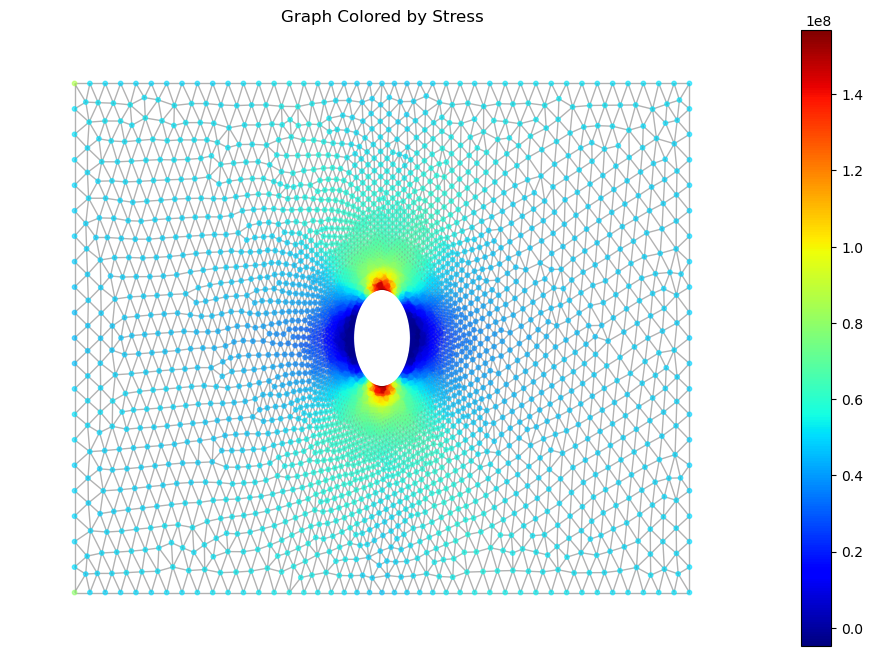

In [22]:
value = sxx

fig, ax = plt.subplots(figsize=(12, 8))

# Draw the graph on the given axis
nx.draw(G, pos, node_size=10, edge_color="gray", alpha=0.6,
        node_color=value, cmap="jet", vmin=value.min(), vmax=value.max(),
        ax=ax)

# Create a mappable and assign the stress values to it for the colorbar
mappable = plt.cm.ScalarMappable(cmap="jet")
mappable.set_array(value)

# Add the colorbar to the figure, using the axis
fig.colorbar(mappable, ax=ax)

ax.set_title("Graph Colored by Stress")
plt.show()

In [ ]:
def export_to_vtk(graph, output, filename="output.vtk"):
    components = ['u', 'v', 'sxx', 'syy', 'sxy']

    node_positions = graph.x.cpu().numpy()
    if node_positions.shape[1] == 2:  # If only (x, y) coordinates are given
        node_positions = np.hstack([node_positions, np.zeros((node_positions.shape[0], 1))])  # Append z=0
    out_values = output.cpu().detach().numpy()
    edge_id = graph.edge_index.cpu().T.numpy()

    cells = [('line', edge_id)]

    point_data = {components[i]: out_values[:, i] for i in range(len(components))}

    mesh = meshio.Mesh(points=node_positions, cells=cells, point_data=point_data)
    mesh.write(filename)

In [ ]:
data = obj.graph
out = test.model(data)
filename = "data/output.vtk"

export_to_vtk(data, out, filename)